In [1]:
from smt.utils.sm_test_case import SMTestCase
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from smt.surrogate_models import KRG

from smt.applications.explainability_tools import PDFeatureImportanceDisplay

from smt.problems import MixedCantileverBeam
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import MixedIntegerKrigingModel
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
import numpy as np
import unittest

In [2]:
ndoe = 300
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
x = sampling(ndoe)
y = fun(x)

feature_names = [
    r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$',
    r'$q$', r'$\lambda$', r'$t_{c}$', r'$N_{z}$',
    r'$W_{dg}$', r'$W_{p}$',
]

sm = KRG(
    theta0=[1e-2] * x.shape[1],
    print_prediction=False
)
sm.set_training_values(x, y)
sm.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 300
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  5.8300838


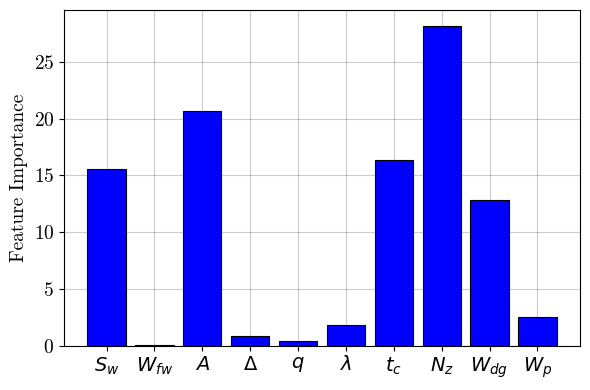

In [4]:
model = sm
pdd_importance = PDFeatureImportanceDisplay.from_surrogate_model(model, x, feature_names=feature_names)
pdd_importance_fig = pdd_importance.plot()
pdd_importance_fig

In [7]:
assert len(pdd_importance.feature_importances) == x.shape[1] 

In [8]:
ndoe = 100
fun = MixedCantileverBeam()
# Design space
ds = DesignSpace([
    CategoricalVariable(values=[str(i + 1) for i in range(12)]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
x = fun.sample(ndoe)
y = fun(x)

# Name of the features
feature_names = [r'$\tilde{I}$', r'$L$', r'$S$']
# Index for categorical features
categorical_feature_indices = [0]
# create mapping for the categories
categories_map = dict()
for feature_idx in categorical_feature_indices:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }

sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )
sm.set_training_values(x, np.array(y))
sm.train()

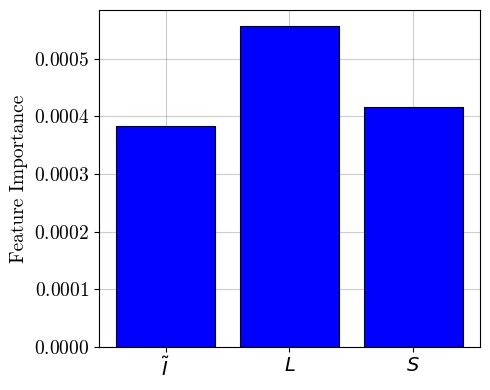

In [9]:
model = sm
pdd_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, x, feature_names=feature_names, categorical_feature_indices=categorical_feature_indices
)
pdd_importance_fig = pdd_importance.plot()
pdd_importance_fig

In [10]:
assert len(pdd_importance.feature_importances) == x.shape[1] 